<a href="https://colab.research.google.com/github/PomesHouse/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/%5BReview%5DVAEmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE (Variational autoencoder)
---
논문: 

https://arxiv.org/pdf/1312.6114.pdf

참고:

https://taeu.github.io/paper/deeplearning-paper-vae/

https://process-mining.tistory.com/161


https://di-bigdata-study.tistory.com/4?category=848869 (1)

https://di-bigdata-study.tistory.com/5?category=848869 (2)





**Goal**
* 주어진 training data의 p_data(x)(확률밀도함수)가 어떤 분포를 가지고 있다면, sample 모델 p_model(x) 역시 같은 분포를 가지면서, (sampling 부분)
* 그 모델을 통해 나온 inference 값이 새로운 x라는 데이터이길 바란다. (Generation 부분)

## VAE Structure

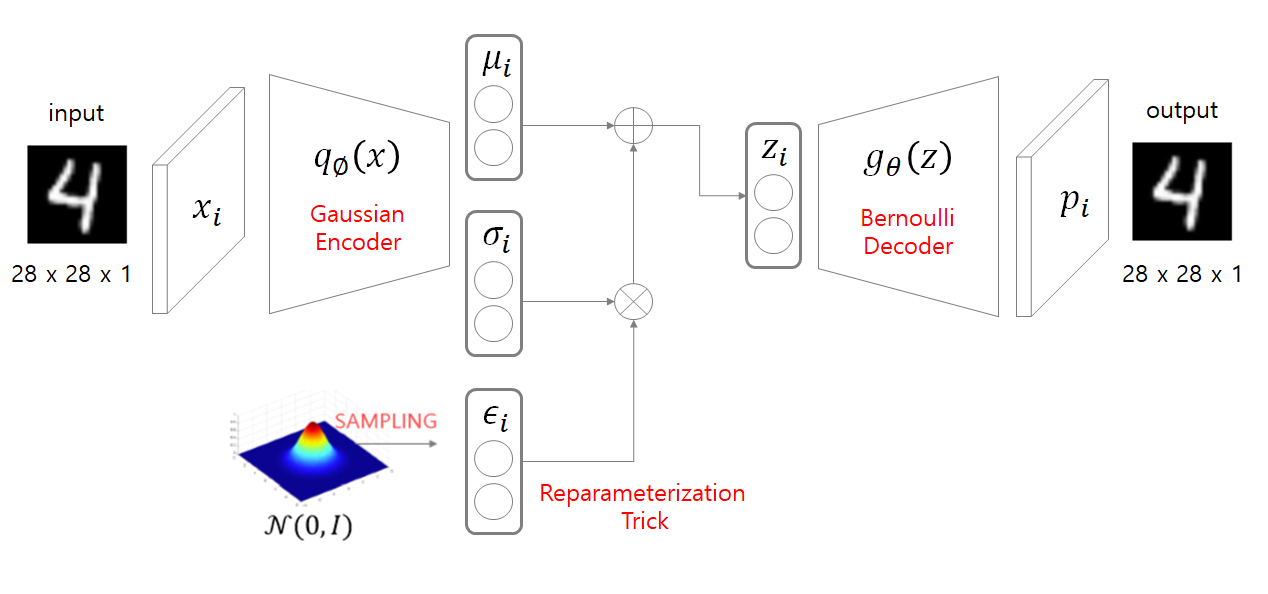

### 1.Encoder

Input X의 아웃풋은 μᵢ,  σᵢ. 




In [ ]:
import numpy as np
import keras
from tensorflow.keras import layers, models
from keras import backend as K

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2 # == hidden,  latent variable z는 feature를 가진 vector로 이해하면 좋다. 

# x가 주어졌을 때, z값의 분포의 평균과 분산을 output으로 내는 함수
input_img = keras.Input(shape = img_shape)
x = layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(input_img)
x = layers.Conv2D(64, 3, padding = 'same', activation = 'relu', strides = (2,2))(x)
x = layers.Conv2D(64, 3, padding = 'same', activation = 'relu')(x)
x = layers.Conv2D(64, 3, padding = 'same', activation = 'relu')(x)

shape_before_flattening = K.int_shape(x) # return tuple of integers of shape of x

x = layers.Flatten()(x)
x = layers.Dense(32, activation = 'relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

> Encoder 함수의 output은 latent variable의 분포의 𝜇 와 𝜎 를 내고, 이 output값을 표현하는 확률밀도함수를 생각해볼 수 있다.

### 2. Reparameterization Trick (Sampling)

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], latent_dim), mean = 0., stddev = 1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

데이터의 확률분포와 같은 분포에서 sampling을 해야한다. 하지만 그냥 sampling을 한다면 sampling한 값들을 backpropagation할 수 없는데, 이를 해결하기 위해 reparameterization trick을 사용한다.

정규분포에서 샘플링한 epsilon을 분산과 곱하고 평균을 더해도 그냥 정규분포에서 샘플링한 값과 같은 분포를 가진다. 

> latent variable에서 sample된 z라는 value(=decoder input)가 만들어진다. 

### 3. Decoder

In [ ]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation = 'relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding = 'same', activation = 'relu', strides = (2,2))(x)
x = layers.Conv2D(1, 3, padding = 'same', activation = 'sigmoid')(x)

decoder = models.Model(decoder_input, x)
z_decoded = decoder(z)

z 값을 g 함수(decoder)에 넣고 deconv(코드에서는 Conv2DTranspose)를 해 원래 이미지 사이즈의 아웃풋 z_decoded가 나오게 된다. 이때 p_data(x)의 분포를 Bernoulli 로 가정했으므로(이미지 recognition 에서 Gaussian 으로 가정할때보다 Bernoulli로 가정해야 의미상 그리고 결과상 더 적절했기 때문) output 값은 0~1 사이 값을 가져야하고, 이를 위해 activatino function을 sigmoid로 설정해주었다. (Gaussian 분포를 따른다고 가정하고 푼다면 아래 loss를 다르게 설정해야한다.)

## Loss Function

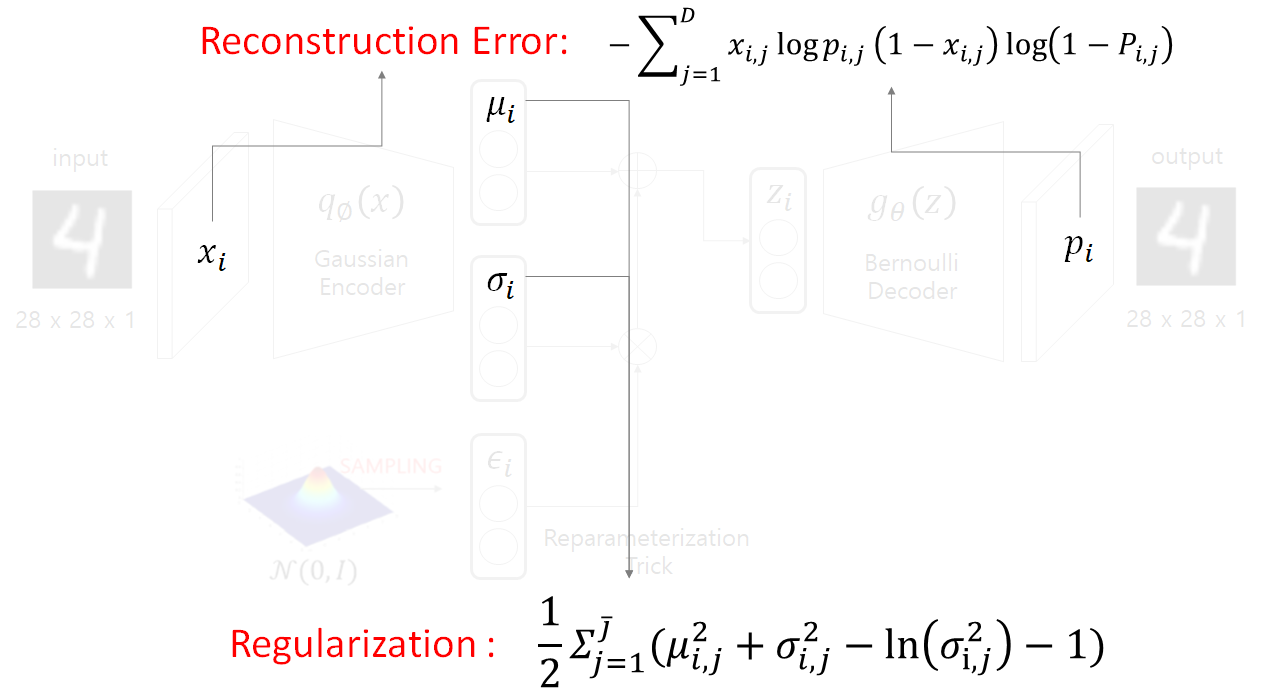

In [ ]:
def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    # Reconstruction Loss
    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    # Regularization Loss
    kl_loss   = -5e-4 * K.mean( 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)


1. 
Reconstruction Loss는 X와 새로 만들어진 아웃풋인 New X와의 관계 살펴본다. 이때 디코더 부분의 pdf는 Bernoulli 분포를 따른다고 가정했으므로 그 둘간의 cross entropy를 구한다.

2. X가 원래 가지는 분포와 동일한 분포를 가지게 학습하게 하기위해 true 분포를 approximate 한 함수의 분포에 대한 loss term이 Regularization Loss다. 이때 loss는 true pdf 와 approximated pdf간의 D_kl(두 확률분포의 차이(거리))을 계산한다.
( helps learn well-formed latent spaces and reduce overfitting)

cross-entropy 참고 

https://androidkt.com/choose-cross-entropy-loss-function-in-keras/


KL divergence 참고

https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence


https://hyunw.kim/blog/2017/10/27/KL_divergence.html

https://hwiyong.tistory.com/408
